生成的答案打分用

In [1]:
# %env LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1
# %env LLM_API_KEY=替换为自己的key

In [2]:
# %%capture --no-stderr
# !pip install -U langchain langchain_community langchain_openai pypdf sentence_transformers chromadb shutil

In [ ]:
# import langchain, langchain_community, pypdf, sentence_transformers, chromadb, langchain_core

# for module in (langchain, langchain_core, langchain_community, pypdf, sentence_transformers, chromadb):
#     print(f"{module.__name__:<30}{module.__version__}")

In [4]:
import os
import pandas as pd

In [5]:
expr_version = 'retrieval_v2_multi_query'

preprocess_output_dir = r""
expr_dir = os.path.join(os.path.pardir, 'experiments', expr_version)

# 读取文档

In [6]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(os.path.join(os.path.pardir, 'data_test', 'GeoChat.pdf'))
documents = loader.load()

qa_df = pd.read_excel(os.path.join(preprocess_output_dir, 'question_answer.xlsx'))

d:\Anaconda\envs\gold-yolo\lib\site-packages\pypdf\_crypt_providers\_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from this module in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4


# 文档切分

In [7]:
from uuid import uuid4
import os
import pickle

from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_docs(documents, filepath, chunk_size=400, chunk_overlap=40, seperators=['\n\n\n', '\n\n'], force_split=False):
    if os.path.exists(filepath) and not force_split:
        print('found cache, restoring...')
        return pickle.load(open(filepath, 'rb'))

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=seperators
    )
    split_docs = splitter.split_documents(documents)
    for chunk in split_docs:
        chunk.metadata['uuid'] = str(uuid4())

    pickle.dump(split_docs, open(filepath, 'wb'))

    return split_docs

In [8]:
splitted_docs = split_docs(documents, os.path.join(preprocess_output_dir, 'split_docs.pkl'), chunk_size=500, chunk_overlap=50)

found cache, restoring...


# 检索

In [9]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.vectorstores import Chroma
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

def get_embeddings(model_path):
    embeddings = HuggingFaceBgeEmbeddings(
        model_name=model_path,
        model_kwargs={'device': device},
        encode_kwargs={'normalize_embeddings': True},
        # show_progress=True
        query_instruction='Generate a representation for this sentence to retrieve related articles：'
    )
    return embeddings

device: cuda


In [10]:
import shutil
from langchain_community.vectorstores import Chroma

# 此处可以替换为本地路径
model_path = 'BAAI/bge-large-en-v1.5'

persist_directory = os.path.join(expr_dir, 'chroma')
shutil.rmtree(persist_directory, ignore_errors=True)

embeddings = get_embeddings(model_path)
vector_db = Chroma.from_documents(
    splitted_docs,
    embedding=embeddings,
    persist_directory=persist_directory
)

d:\Anaconda\envs\gold-yolo\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [11]:
test_df = qa_df[(qa_df['dataset'] == 'test') & (qa_df['qa_type'] == 'detailed')]

## 不使用Multi-Query

In [12]:
def get_emb_retriever(k):
    return vector_db.as_retriever(search_kwargs={'k': k})

In [13]:
from tqdm.auto import tqdm

def get_hit_stat_df(get_retriever_fn, top_k_arr=list(range(1, 9))):
    hit_stat_data = []
    pbar = tqdm(total=len(top_k_arr) * len(test_df))
    for k in top_k_arr:
        pbar.set_description(f'k={k}')
        retriever = get_retriever_fn(k)
        for idx, row in test_df.iterrows():
            question = row['question']
            true_uuid = row['uuid']
            # 在langchain_core/retrievers.py中，get_relevant_documents方法已经被标注为禁用，将在0.3.0版本移除
            # 推荐使用invoke方法
            chunks = retriever.invoke(question)[:k]
            retrieved_uuids = [doc.metadata['uuid'] for doc in chunks]

            hit_stat_data.append({
                'question': question,
                'top_k': k,
                'hit': int(true_uuid in retrieved_uuids),
                'retrieved_chunks': len(chunks)
            })
            pbar.update(1)
    hit_stat_df = pd.DataFrame(hit_stat_data)
    return hit_stat_df

In [14]:
orig_query_hit_stat_df = get_hit_stat_df(get_emb_retriever)
orig_query_hit_stat_df['multi_query'] = 'w/o'

k=8: 100%|██████████| 800/800 [00:12<00:00, 64.46it/s]


In [15]:
orig_query_hit_stat_df.groupby('top_k')['hit'].mean().reset_index().rename(columns={'hit': 'hit_rate'})

,top_k,hit_rate
0,1,0.31
1,2,0.49
2,3,0.56
3,4,0.60
4,5,0.66
5,6,0.66
6,7,0.68
7,8,0.68


## 使用Multi Query

In [16]:
from langchain_community.chat_models import ChatOllama

llm = ChatOllama(base_url='http://localhost:11434', model='qwen2:7b-instruct')

### 最简用法

In [17]:
from langchain.retrievers import MultiQueryRetriever
import logging

def get_multi_query_retriever(k):
    retriever = MultiQueryRetriever.from_llm(
        retriever=vector_db.as_retriever(search_kwargs={'k': k}),
        llm=llm
    )
    return retriever

logging.basicConfig()
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

In [18]:
get_multi_query_retriever(k=2).invoke('What type of model is GeoChat?')

INFO:langchain.retrievers.multi_query:Generated queries: ['1. Could you clarify which kind of architecture supports GeoChat?', '2. Which category does the underlying framework for GeoChat fall under?', '3. In what modeling paradigm does GeoChat operate?']


[Document(metadata={'page': 3, 'source': './data_test/GeoChat.pdf', 'uuid': '94b6816d-3791-43e5-a3e3-6a3068a63c8c'}, page_content="<System Message>A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to thehuman's questions.. Figure 2. An overview of GeoChat - the first grounded large vision-language model for remote sensing. Given an image input together\nwith a user query, a visual backbone is first used to encode patch-level tokens at a higher resolution via interpolating positional encodings."),
 Document(metadata={'page': 0, 'source': './data_test/GeoChat.pdf', 'uuid': '33890465-ae6c-42b4-85cf-b5d2e06849fc'}, page_content='Figure 1. GeoChat can accomplish multiple tasks for remote-\nsensing (RS) image comprehension in a unified framework. Given\nsuitable task tokens and user queries, the model can generate visu-\nally grounded responses (text with corresponding object locations\n- shown on top), visual q

In [20]:
len(get_multi_query_retriever(k=2).invoke('What type of model is GeoChat?'))

INFO:langchain.retrievers.multi_query:Generated queries: ['1. Can you describe the architecture of GeoChat?', '2. Which category does GeoChat belong to among chat models?', '3. Is GeoChat classified as a conventional or novel model in geographic communication?']


3

由于是对每个相似问做召回，因此最终的结果是这些召回的并集，通常会大于k

### 使用Chain

#### 官方示例

这部分代码执行会报错，应该是Langchain官方升级没有充分测试，已经有人提到这个问题了

- https://github.com/langchain-ai/langchain/issues/17343
- https://github.com/langchain-ai/langchain/issues/17352

In [22]:
from langchain.callbacks.manager import CallbackManagerForLLMRun
from langchain.llms.base import LLM
from langchain.llms import Ollama
from langchain.chains import LLMChain
from typing import Optional, List, Any
from pydantic import BaseModel, Field
from langchain.prompts import PromptTemplate
from langchain.output_parsers import PydanticOutputParser

class LineList(BaseModel):
    lines: List[str] = Field(description="Lines of text")

class LineListOutputParser(PydanticOutputParser):
    def __init__(self) -> None:
        super().__init__(pydantic_object=LineList)

    def parse(self, text: str) -> LineList:
        print(text)
        lines = text.strip().split("\n")
        return LineList(lines=lines)

query_prompt = PromptTemplate(
    input_variables=['question', 'n_sim_query'],
    template = """你是一个AI语言模型助手。你的任务是基于给定的原始问题，再生成出来最相似的5个不同的版本。\
你的目标是通过生成用户问题不同视角的版本，帮助用户克服基于距离做相似性查找的局限性。\
使用换行符来提供这些不同的问题，使用换行符来切分不同的问题，不要包含数字序号，仅返回结果即可，不要添加任何其他描述性文本。
原始问题：{question}
"""
)
output_parser = LineListOutputParser()
llm_chain = LLMChain(llm=llm, prompt=query_prompt, output_parser=output_parser)

In [23]:
# llm_chain.invoke(qa_df.iloc[0]['question'])

OutputParserException: Failed to parse LineList from completion 1. Got: 1 validation error for LineList
  Input should be a valid dictionary or instance of LineList [type=model_type, input_value=1, input_type=int]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type

#### 自定义Chain

In [27]:
from langchain.prompts import PromptTemplate
import re

def get_query_gen_chain(n_sim_queries):
    prompt = PromptTemplate(
        input_variables=['question', 'n_sim_queries'],
    #     template = """你是一个AI语言模型助手。你的任务是基于给定的原始问题，再生成出来最相似的{n_sim_queries}个不同的版本。\
    # 你的目标是通过生成用户问题不同视角的版本，帮助用户克服基于距离做相似性查找的局限性。\
    # 使用换行符来提供这些不同的问题，使用换行符来切分不同的问题，不要包含数字序号，仅返回结果即可，不要添加任何其他描述性文本。
    # 原始问题：{question}
    # """
    template = """You are an AI language model assistant. Your task is to generate the most similar {n_sim_queries} different versions based on the given original question.\
Your goal is to help users overcome the limitations of distance-based similarity search by generating different perspectives of user questions.\
Use line breaks to provide these different questions, use line breaks to split different questions, do not include numerical serial numbers, only return the results, and do not add any other descriptive text.
Original question: {question}
"""
    )
    queries_gen_chain = (
        prompt.partial(n_sim_queries=n_sim_queries)
        | llm
        # 有时候模型不遵循指令，把前面的序号去掉
        # | (lambda x: re.sub(r'\d+\.\s', '', x.content))
        # 有时候模型不遵循指令，把前面的序号、- 去掉
        | (lambda x: [
            re.sub(r'(^\-\s+)|(^\d+\.\s)', '', item.strip()) 
            for item in x.content.split('\n') if item.strip() != ''
        ])
    )
    return queries_gen_chain

测试一下

In [28]:
queries_gen_chain = get_query_gen_chain(3)
queries_gen_chain.invoke({'question': 'What type of model is GeoChat?'})

['What kind of model does GeoChat represent?',
 'Could you clarify the model behind GeoChat?',
 'Is there a specific model that defines GeoChat?']

In [29]:
def get_multi_query_retriever(k):
    retriever = MultiQueryRetriever.from_llm(
        retriever=vector_db.as_retriever(search_kwargs={'k': k}),
        llm=llm
    )
    return retriever

def get_multi_query_retriever_v2(k):
    retriever = MultiQueryRetriever(
        retriever=vector_db.as_retriever(search_kwargs={'k': k}), llm_chain=queries_gen_chain
    )
    return retriever

def get_multi_query_retriever_v3(k):
    retriever = MultiQueryRetriever(
        retriever=vector_db.as_retriever(search_kwargs={'k': k}), llm_chain=queries_gen_chain
    )
    # 检查源代码可以发现，检索时，默认是把原始问题排除出去了，增加一个包含原始查询的尝试
    retriever.include_original = True
    return retriever

In [30]:
multi_query_hit_stat_df = get_hit_stat_df(get_multi_query_retriever)
multi_query_hit_stat_df['multi_query'] = 'w/ multi_query'

k=1:   3%|▎         | 24/800 [04:04<2:11:13, 10.15s/it]INFO:backoff:Backing off send_request(...) for 0.6s (requests.exceptions.ProxyError: HTTPSConnectionPool(host='us.i.posthog.com', port=443): Max retries exceeded with url: /batch/ (Caused by ProxyError('Cannot connect to proxy.', RemoteDisconnected('Remote end closed connection without response'))))
INFO:langchain.retrievers.multi_query:Generated queries: ['1. Could you explain how the model incorporates and utilizes specific geographical areas or regions in its functionality?', '2. In what way does the model take into account regional placements when processing or analyzing data?', '3. Can you describe the process through which the model leverages information about designated zones or territories for its operations?']
k=4:  40%|███▉      | 316/800 [56:00<1:30:38, 11.24s/it]INFO:backoff:Backing off send_request(...) for 0.7s (requests.exceptions.ProxyError: HTTPSConnectionPool(host='us.i.posthog.com', port=443): Max retries exceede

从日志中可以看出，使用`MultiQueryRetriever.from_llm`构造的相似问，可以看出，都带有数字前缀，而且有些是英文问题，这主要是由于内置的Prompt是英文的

In [31]:
multi_query_v2_hit_stat_df = get_hit_stat_df(get_multi_query_retriever_v2)
multi_query_v2_hit_stat_df['multi_query'] = 'w/ multi_query_llm_chain'

k=1:   4%|▍         | 33/800 [05:12<2:10:44, 10.23s/it]INFO:backoff:Backing off send_request(...) for 0.2s (requests.exceptions.ProxyError: HTTPSConnectionPool(host='us.i.posthog.com', port=443): Max retries exceeded with url: /batch/ (Caused by ProxyError('Cannot connect to proxy.', RemoteDisconnected('Remote end closed connection without response'))))
INFO:langchain.retrievers.multi_query:Generated queries: ['What role does interpolation play in the transformer architecture of the CLIP model?', 'How does the transformer mechanism within the CLIP framework utilize interpolation for information processing?', 'In what way does the CLIP model incorporate interpolation when handling visual and textual data simultaneously through its transformer structure?']
k=1:   5%|▌         | 40/800 [06:23<2:08:27, 10.14s/it]INFO:backoff:Backing off send_request(...) for 0.7s (requests.exceptions.SSLError: HTTPSConnectionPool(host='us.i.posthog.com', port=443): Max retries exceeded with url: /batch/ (C

KeyboardInterrupt: 

In [32]:
multi_query_v3_hit_stat_df = get_hit_stat_df(get_multi_query_retriever_v3)
multi_query_v3_hit_stat_df['multi_query'] = 'w/ multi_query_llm_chain_orig_query'

INFO:langchain.retrievers.multi_query:Generated queries: ['Proposed solutions for overcoming distance-based similarity challenges?', 'Addressing issues with traditional distance metrics in search algorithms?', 'Alternatives to distance-based methods for improving user queries?']
INFO:langchain.retrievers.multi_query:Generated queries: ['What category does natural image data belong to?', 'Can you name a specific type of data found within natural images?', 'Is there a particular kind of data commonly utilized in the analysis of natural images?']


KeyboardInterrupt: 

In [28]:
hit_stat_df = pd.concat([orig_query_hit_stat_df, multi_query_hit_stat_df, multi_query_v2_hit_stat_df, multi_query_v3_hit_stat_df])

In [29]:
hit_stat_df.groupby(['multi_query', 'top_k'])['hit'].mean().reset_index().rename(columns={'hit': 'hit_rate'})

,multi_query,top_k,hit_rate
0,w/ multi_query,1,0.344086
1,w/ multi_query,2,0.537634
2,w/ multi_query,3,0.591398
3,w/ multi_query,4,0.677419
4,w/ multi_query,5,0.720430
5,w/ multi_query,6,0.752688
6,w/ multi_query,7,0.731183
7,w/ multi_query,8,0.741935
8,w/ multi_query_llm_chain,1,0.397849
9,w/ multi_query_llm_chain,2,0.569892


<Axes: xlabel='top_k', ylabel='hit'>

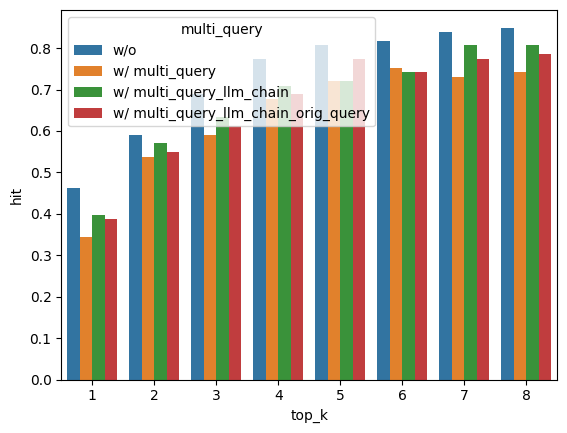

In [30]:
import seaborn as sns

sns.barplot(x='top_k', y='hit', hue='multi_query', data=hit_stat_df, errorbar=None)

# 预测

In [31]:
from langchain.llms import Ollama

ollama_llm = Ollama(
    model='qwen2:7b-instruct',
    base_url='http://localhost:11434'
)

In [32]:
ollama_llm.invoke('你是谁')

'我是阿里云研发的一款超大规模语言模型，我叫通义千问。作为一个AI助手，我的目标是帮助用户获得准确、有用的信息，解决他们的问题和困惑。无论是学术知识、技术问题、日常建议还是娱乐话题，我都尽力提供高质量的回答。如果你有任何问题需要解答或有任务需要完成，请随时向我提问！'

In [33]:
def rag(question, n_chunks=3):
    prompt_tmpl = """
你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
回答保持简洁，不必重复问题，不要添加描述性解释和与答案无关的任何内容。
已知信息：
<<<<context>>>
{{knowledge}}
<<<</context>>>

问题：{{question}}
请回答：
""".strip()

    retriever = get_multi_query_retriever_v2(n_chunks)
    chunks = retriever.invoke(question)[:n_chunks]
    assert len(chunks) == n_chunks
    
    prompt = prompt_tmpl.replace('{{knowledge}}', '\n\n'.join([doc.page_content for doc in chunks])).replace('{{question}}', question)

    return ollama_llm(prompt), chunks

In [34]:
print(rag('2023年10月美国ISM制造业PMI指数较上月有何变化？')[0])

INFO:langchain.retrievers.multi_query:Generated queries: ['2023年10月的美国ISM制造业PMI是否比9月有变动？', '2023年10月与前一个月相比，美国ISM制造业PMI有什么不同？', '从2023年9月到10月，美国ISM制造业PMI指数有何变化？']
/opt/anaconda3/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


2023年10月美国ISM制造业PMI指数较上个月大幅下降了2.3个百分点。


In [35]:
prediction_df = qa_df[qa_df['dataset'] == 'test'][['uuid', 'question', 'qa_type', 'answer']].rename(columns={'answer': 'ref_answer'})

def predict(prediction_df, n_chunks):
    prediction_df = prediction_df.copy()
    answer_dict = {}

    for idx, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        uuid = row['uuid']
        question = row['question']
        answer, chunks = rag(question, n_chunks=n_chunks)
        assert len(chunks) <= n_chunks
        answer_dict[question] = {
            'uuid': uuid,
            'ref_answer': row['ref_answer'],
            'gen_answer': answer,
            'chunks': chunks
        }
    prediction_df.loc[:, 'gen_answer'] = prediction_df['question'].apply(lambda q: answer_dict[q]['gen_answer'])
    prediction_df.loc[:, 'chunks'] = prediction_df['question'].apply(lambda q: answer_dict[q]['chunks'])

    return prediction_df

In [36]:
n_chunks = 3

pred_df = predict(prediction_df, n_chunks=n_chunks)

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:langchain.retrievers.multi_query:Generated queries: ['发布的组织或实体是谁？', '谁负责公布此报告？', '什么机构发布了该报告？']
INFO:langchain.retrievers.multi_query:Generated queries: ['何时发布了报告？', '报告的具体发布时间是哪天？', '你能告诉我报告发布的日期吗？']
INFO:langchain.retrievers.multi_query:Generated queries: ['未来全球经济增长的特征是什么？', '2023年全球经济发展的趋势如何体现？', '全球经济增长在2023年的主要表现形式有哪些？']
INFO:langchain.retrievers.multi_query:Generated queries: ['当前全球贸易的增加态势如何评估？', '全球商业交流的增长趋势在最近几年有何表现？', '如何量化全球贸易规模和速度的变化？']
INFO:langchain.retrievers.multi_query:Generated queries: ['全球在2024年的经济恢复前景怎样预测？', '2024年全球经济复兴的期望值是什么？', '到2024年，全球经济会实现怎样的反弹与复原？']
INFO:langchain.retrievers.multi_query:Generated queries: ['报告中讨论了哪些当前备受关注的话题？', '在这份报告里，有哪些热门议题得到了阐述和分析？', '可以告诉我报告中涉及的几个关键焦点领域吗？']
INFO:langchain.retrievers.multi_query:Generated queries: ['寻找研究团队的联系方式是什么步骤？', '报告中的学术团体如何取得联系？', '探索报道研究的团队是否提供联系方式？']
INFO:langchain.retrievers.multi_query:Generated queries: ['2023年全球经济的增长驱动力会有哪些转变？', '预测在2023年中影响全球经济发展的主要增长因素是什么？', '到2023年，推动全球经济增长的主要力量会是哪些？它们与现在相比有何不同？']
IN

# 评估

In [37]:
from langchain_openai import ChatOpenAI
import time

judge_llm = ChatOpenAI(
    api_key=os.environ['LLM_API_KEY'],
    base_url=os.environ['LLM_BASE_URL'],
    model_name='qwen2-72b-instruct',
    temperature=0
)

def evaluate(prediction_df):
    """
    对预测结果进行打分
    :param prediction_df: 预测结果，需要包含问题，参考答案，生成的答案，列名分别为question, ref_answer, gen_answer
    :return 打分模型原始返回结果
    """
    prompt_tmpl = """
你是一个经济学博士，现在我有一系列问题，有一个助手已经对这些问题进行了回答，你需要参照参考答案，评价这个助手的回答是否正确，仅回复“是”或“否”即可，不要带其他描述性内容或无关信息。
问题：
<question>
{{question}}
</question>

参考答案：
<ref_answer>
{{ref_answer}}
</ref_answer>

助手回答：
<gen_answer>
{{gen_answer}}
</gen_answer>
请评价：
    """
    results = []

    for _, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        question = row['question']
        ref_answer = row['ref_answer']
        gen_answer = row['gen_answer']

        prompt = prompt_tmpl.replace('{{question}}', question).replace('{{ref_answer}}', str(ref_answer)).replace('{{gen_answer}}', gen_answer).strip()
        result = judge_llm.invoke(prompt).content
        results.append(result)

        time.sleep(1)
    return results

In [38]:
pred_df['raw_score'] = evaluate(pred_df)

  0%|          | 0/100 [00:00<?, ?it/s]

In [39]:
pred_df['raw_score'].unique()

array(['是', '否'], dtype=object)

In [40]:
pred_df.loc[:, 'score'] = pred_df['raw_score'].replace({'是': 1, '否': 0})
_ = pred_df.pop('raw_score')

/tmp/ipykernel_3815971/1969662583.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pred_df.loc[:, 'score'] = pred_df['raw_score'].replace({'是': 1, '否': 0})


In [41]:
pred_df['score'].mean()

0.71

In [42]:
pred_df.to_excel(os.path.join(expr_dir, 'prediction.xlsx'), index=False)